In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/MyDrive' #path to the file final_.csv on my gdrive

Mounted at /content/gdrive


To work with casboost need to install it with `[!pip install catboost]`

In [2]:
!pip install catboost

     |████████████████████████████████| 76.4 MB 25 kB/s 


In [3]:
from pathlib import Path
import pandas as pd
# from sklearn.model_selection import train_test_split
import catboost as cb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import plotly.express as px
# from sklearn.metrics import mean_absolute_percentage_error
%matplotlib inline

In [4]:
path = Path(root_path)

In [5]:
filename = 'final_.csv'
path.resolve()

PosixPath('/content/gdrive/MyDrive')

In [6]:
df_final = pd.read_csv(path/filename, dtype={'line_total_order_qty' : int, 'dock_imp_day' : "string"})

In [7]:
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
days_until_promo_ends,780363.0,8.520877,14.051616,0.0000,0.000000,2.000000,10.000000,72.000000
next_us_hday,780363.0,26.762193,22.874701,0.0000,9.000000,21.000000,37.000000,104.000000
prev_us_hday,780363.0,28.310218,24.768507,0.0000,9.000000,21.000000,40.000000,104.000000
month,780363.0,5.702591,28.450696,-999.0000,4.000000,6.000000,9.000000,12.000000
month_day,780363.0,15.590201,8.821361,1.0000,8.000000,16.000000,23.000000,31.000000
days_until_payday,780363.0,14.884761,8.824470,0.0000,7.000000,15.000000,23.000000,30.000000
pc9,780363.0,1038.957157,564.044840,0.0000,566.000000,1054.000000,1525.000000,2079.000000
gender,780363.0,0.079754,0.270912,0.0000,0.000000,0.000000,0.000000,1.000000
size_group,780363.0,0.911926,0.489720,0.0000,1.000000,1.000000,1.000000,2.000000
style,780363.0,11.751718,12.828415,0.0000,0.000000,5.000000,26.000000,34.000000


In [8]:
df_final= df_final[df_final['LM_unit_sold_monthly_mean'] != -999]

df_final.head()

,date,days_until_promo_ends,next_us_hday,prev_us_hday,month,month_day,week_day,days_until_payday,pc9,gender,size_group,style,interacted_price,pricing,pc3,pc5,category,product_item_type,fit,regular_price,overall,reg,mk,major_minimum_value,major_multiple_items,site_wide,upto,special,markdown,non_markdown,spend_paid_social,spend_paid_search,spend_affiliate,spend_cses,spend_display,spend_total_demand_generation,dock_imp_day,pricing_period,possible_final_price,selected,LM_unit_sold_monthly_mean,LM_unit_sold_monthly_sum_rolling_mean_3,LM_overall_unit_sold_monthly_mean,line_total_order_qty,dis_from_msrp
19644,2018-04-30,0.0,28.0,70.0,4.0,30.0,Monday,0.0,38,0,1,26,32.97,0,9,12,2,10,7,58.0,20.0,25.0,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20524.0,95770.0,26894.0,21122.0,0.0,164310.0,-999,1,26.376,0.0,3.0,1.333333,2.311538,2,0.545241
19646,2018-04-30,0.0,28.0,70.0,4.0,30.0,Monday,0.0,43,0,1,33,58.00,1,11,15,2,10,1,58.0,20.0,25.0,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20524.0,95770.0,26894.0,21122.0,0.0,164310.0,-999,1,43.500,0.0,2.0,3.000000,2.311538,3,0.250000
19647,2018-04-30,0.0,28.0,70.0,4.0,30.0,Monday,0.0,44,0,1,33,58.00,1,11,15,2,10,1,58.0,20.0,25.0,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20524.0,95770.0,26894.0,21122.0,0.0,164310.0,-999,1,43.500,0.0,4.0,5.666667,2.311538,1,0.250000
19648,2018-04-30,0.0,28.0,70.0,4.0,30.0,Monday,0.0,45,0,1,33,58.00,1,11,15,2,10,1,58.0,20.0,25.0,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20524.0,95770.0,26894.0,21122.0,0.0,164310.0,-999,1,43.500,0.0,1.0,2.666667,2.311538,3,0.250000
19649,2018-04-30,0.0,28.0,70.0,4.0,30.0,Monday,0.0,46,0,1,33,32.97,0,11,15,2,10,1,58.0,20.0,25.0,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20524.0,95770.0,26894.0,21122.0,0.0,164310.0,-999,1,26.376,0.0,1.0,3.333333,2.311538,3,0.545241


In [9]:
# Calculate different in pricing from MSRP, this field is already in the final_.csv. Needs only for original file
# df_final['dis_from_msrp'] = ((df_final['regular_price'] - df_final['possible_final_price']) / df_final['regular_price'])

# Set reg, mk and overall not in % by dividing on 100 May be it;s not nescessary. IMHO this features are not important in out model 
df_final['reg'] =df_final['reg']/100
df_final['mk'] =df_final['mk']/100
df_final['overall'] =df_final['overall']/100

# change name of the week with numbers 0..6
df_final['week_day'] = pd.to_datetime(df_final['date']).dt.dayofweek

# Add column with the week from the first date we have in dataframe.
# Used this to calculate mean of line_total_order_qty.
# Fot the training of the model going to try to use not the sales for one day,
# but instead an average sales of the product for the week.
df_final['period'] = ((pd.to_datetime(df_final['date']) - pd.to_datetime('2018-03-31')).dt.days/7).astype(int)
df_final['avg_toq_per_week'] = df_final.groupby(['pc9', 'period'])['line_total_order_qty'].transform('mean')


df_final['dock_imp_day']= df_final['dock_imp_day'].astype(str)
# df_final['dock_imp_day'].unique()
# count -999 in dock_imp_day
# df_final[df_final['dock_imp_day'] == "Easter"].head()
#convert to dummy tables dock_imp_day. 
# df_final = pd.get_dummies(df_final, columns=['dock_imp_day'])

Model_features - just the list of all columns in our dataframe. Next steps we divede them in ti not a feature, numerical and categorical

In [10]:
model_features = list(df_final.columns)
# model_features

Unique products in our dataset

In [11]:
len(df_final['pc9'].unique())

2036

In [12]:
# just for the case we'd like to run our prediction with one single product (in this case pc9 = 38.)
# df_final[df_final['pc9'] == 38].head(10)

In [13]:

df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709006 entries, 19644 to 780335
Data columns (total 47 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   date                                     709006 non-null  object 
 1   days_until_promo_ends                    709006 non-null  float64
 2   next_us_hday                             709006 non-null  float64
 3   prev_us_hday                             709006 non-null  float64
 4   month                                    709006 non-null  float64
 5   month_day                                709006 non-null  float64
 6   week_day                                 709006 non-null  int64  
 7   days_until_payday                        709006 non-null  float64
 8   pc9                                      709006 non-null  int64  
 9   gender                                   709006 non-null  int64  
 10  size_group                  

In [14]:
not_features =['date',
 'line_total_order_qty',
 'avg_toq_per_week',
 'period',
 'spend_total_demand_generation',
 'dock_imp_day', 
 'style', 
 'pricing',
 'product_item_type',
 'fit',
 'markdown',
 'non_markdown',
 'pricing_period',
 'selected',
 'regular_price',
 'LM_unit_sold_monthly_sum_rolling_mean_3',
 'LM_overall_unit_sold_monthly_mean',
 'possible_final_price',
 'spend_display',
 'overall',
 'reg',
 'mk',
]

In [15]:
cat_features = [
 'days_until_promo_ends',
 'next_us_hday',
 'prev_us_hday',
 'month',
 'month_day',
 'week_day',
 'days_until_payday',
 'pc9',
 'gender',
 'size_group',
#  'style',
#  'pricing',
 'pc3',
 'pc5',
 'category',
#  'product_item_type',
#  'fit',
 'major_minimum_value',
 'major_multiple_items',
 'site_wide',
 'upto',
 'special',
#  'markdown',
#  'non_markdown',
#  'pricing_period',
#  'selected',

# this is the case with dock_imp_day changed for dummy columns. It seems to me this doesn't add any results. 
#  'dock_imp_day_-999',
#  'dock_imp_day_BOGO',
#  'dock_imp_day_BTS',
#  'dock_imp_day_Black Friday',
#  'dock_imp_day_Cyber Monday',
#  'dock_imp_day_Easter',
#  'dock_imp_day_End-of-season sale',
#  'dock_imp_day_Factory',
#  "dock_imp_day_Father's Day",
#  'dock_imp_day_Friends & family',
#  'dock_imp_day_Green Monday',
#  'dock_imp_day_Labor Day',
#  'dock_imp_day_MLK',
#  'dock_imp_day_Memorial Day',
#  'dock_imp_day_Mid-season sale',
#  'dock_imp_day_Mystery sale',
#  'dock_imp_day_NYD',
#  'dock_imp_day_Presidents Day',
#  'dock_imp_day_Veterans Day'
]

In [16]:
num_features = []
features = []
for i in model_features:
    if i not in not_features:
        features.append(i)

for i in features:
    if i not in cat_features:
        num_features.append(i)
    else:
        df_final[i] = df_final[i].apply(lambda x: str(x))
print (len(model_features), len(features), len(num_features), len(cat_features))


47 25 7 18


In [17]:
num_features

['interacted_price',
 'spend_paid_social',
 'spend_paid_search',
 'spend_affiliate',
 'spend_cses',
 'LM_unit_sold_monthly_mean',
 'dis_from_msrp']

In [ ]:
# df_final['avg_toq_per_week'].describe()

In [ ]:
# df_final.info()
# if we d like to predict the sales with an avearge sales more than 3
# df= df_final[df_final['avg_toq_per_week'] > 3]
# df.info()

In [18]:
# using line_total_order_qty as y
X = df_final[features]
y = df_final['line_total_order_qty']


# using an average sales in prediction avg_toq_per_week as y
# X = df[features]
# y = df['avg_toq_per_week']

# df_final['avg_toq_per_week'].describe()

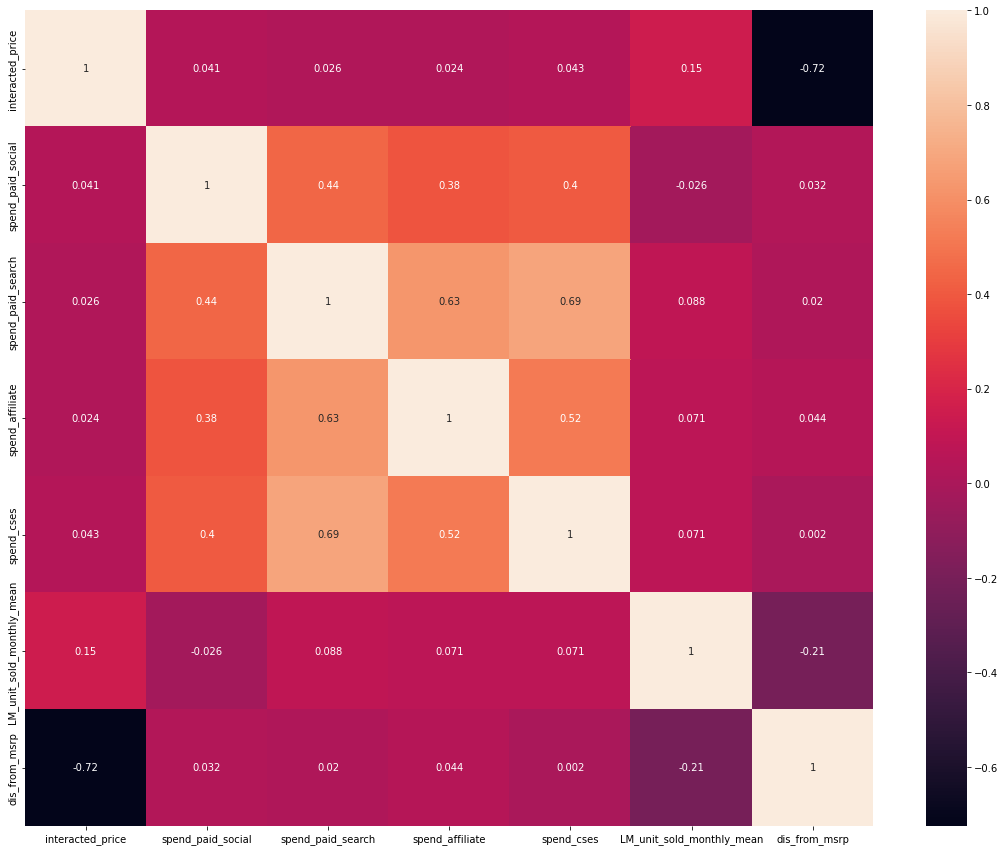

In [19]:
corr_matrix = df_final[num_features].corr()
fig = plt.figure(figsize=(19, 15))
sns.heatmap(corr_matrix, annot=True);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7865e46850>]],
      dtype=object)

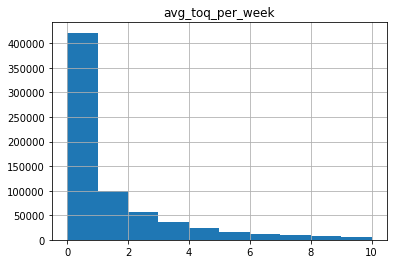

In [20]:
df_final.hist(column= 'avg_toq_per_week', bins =10, range = (0,10),log = False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7866c12050>]],
      dtype=object)

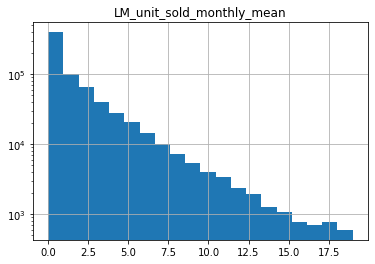

In [21]:
df_final.hist(column='LM_unit_sold_monthly_mean', bins =20, range = (0,19), log=True)

In [22]:
df_final['LM_unit_sold_monthly_mean'].describe()

count    709006.000000
mean          1.827002
std           2.882437
min           0.000000
25%           0.193548
50%           0.709677
75%           2.300000
max          65.400000
Name: LM_unit_sold_monthly_mean, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f786645e150>]],
      dtype=object)

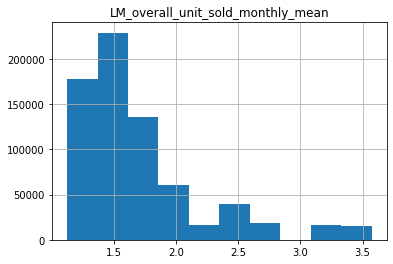

In [23]:
df_final.hist(column='LM_overall_unit_sold_monthly_mean')


In [24]:
#for time based features we do not use random slpit for training and validation set

X_train = X[:int(X.shape[0]*0.70)]
X_val = X[int(X.shape[0]*0.70):]
y_train = y[:int(X.shape[0]*0.70)]
y_val = y[int(X.shape[0]*0.70):]

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(496304, 25) (212702, 25) (496304,) (212702,)


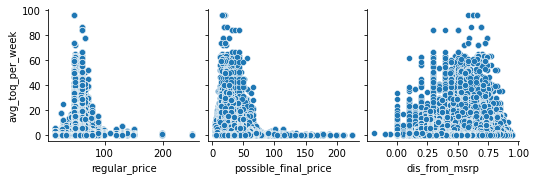

In [25]:
sns.pairplot(data=df_final,
                  x_vars=['regular_price', 'possible_final_price', 'dis_from_msrp'],
                  y_vars=['avg_toq_per_week']);


In [26]:
X_train.columns

Index(['days_until_promo_ends', 'next_us_hday', 'prev_us_hday', 'month',
       'month_day', 'week_day', 'days_until_payday', 'pc9', 'gender',
       'size_group', 'interacted_price', 'pc3', 'pc5', 'category',
       'major_minimum_value', 'major_multiple_items', 'site_wide', 'upto',
       'special', 'spend_paid_social', 'spend_paid_search', 'spend_affiliate',
       'spend_cses', 'LM_unit_sold_monthly_mean', 'dis_from_msrp'],
      dtype='object')

In [27]:
# function to show features importance

def feature_importance(model, data):
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp

In [28]:
# MAPE, but this is wrong metrik for our model
def MAPE(y_true, y_pred): 
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / np.maximum(np.ones(len(y_true)), np.abs(y_true))))*100

In [ ]:
# Just to try Ridge and Lasso, but this models works only with numerical features. Need to convert all categorical features into float or int. 

# from sklearn.linear_model import Ridge, Lasso
# from sklearn.model_selection import cross_val_score

#Linear Regression
# ridge_model = Ridge(alpha=1)
# ridge_model.fit(X_train, y_train)

In [ ]:
# np.mean(cross_val_score(ridge_model,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3))

In [ ]:
# lasso_model = Lasso(alpha=0.13)
# lasso_model.fit(X_train,y_train)

In [ ]:
# np.mean(cross_val_score(lasso_model,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3))

In [ ]:
# ElasticNet. The same needs only numerical features. 
# from sklearn.linear_model import ElasticNet
# elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
# elastic_net.fit(X_train,y_train)

In [ ]:
# np.mean(cross_val_score(elastic_net,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3))

In [29]:
from sklearn.ensemble import RandomForestRegressor
forest_model = RandomForestRegressor(n_estimators=100)
forest_model.get_params()
# np.mean(cross_val_score(forest_model,X_train,y_train,scoring = 'neg_mean_absolute_error', cv= 3))

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [30]:
forest_model.fit(X_train, y_train)
# base_score = forest_model.score(X_val, y_val)
# base_score

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
# np.mean(cross_val_score(forest_model,X_train,y_train,scoring = 'neg_mean_absolute_error', cv= 3))

In [31]:
test_pred_forest = forest_model.predict(X_val)

print("MAE RF: ", mean_absolute_error(y_val, test_pred_forest))
print('R2 RF: ', r2_score(y_val, test_pred_forest))
print('MAPE RF: ', MAPE(y_val, test_pred_forest))

MAE RF:  2.517761375069346
R2 RF:  -0.03048401253326105
MAPE RF:  152.75715475024765


,imp,col
8,0.000347,gender
17,0.001032,upto
15,0.001595,major_multiple_items
18,0.003806,special
14,0.004316,major_minimum_value
9,0.005507,size_group
13,0.006447,category
3,0.007184,month
16,0.007664,site_wide
20,0.014790,spend_paid_search


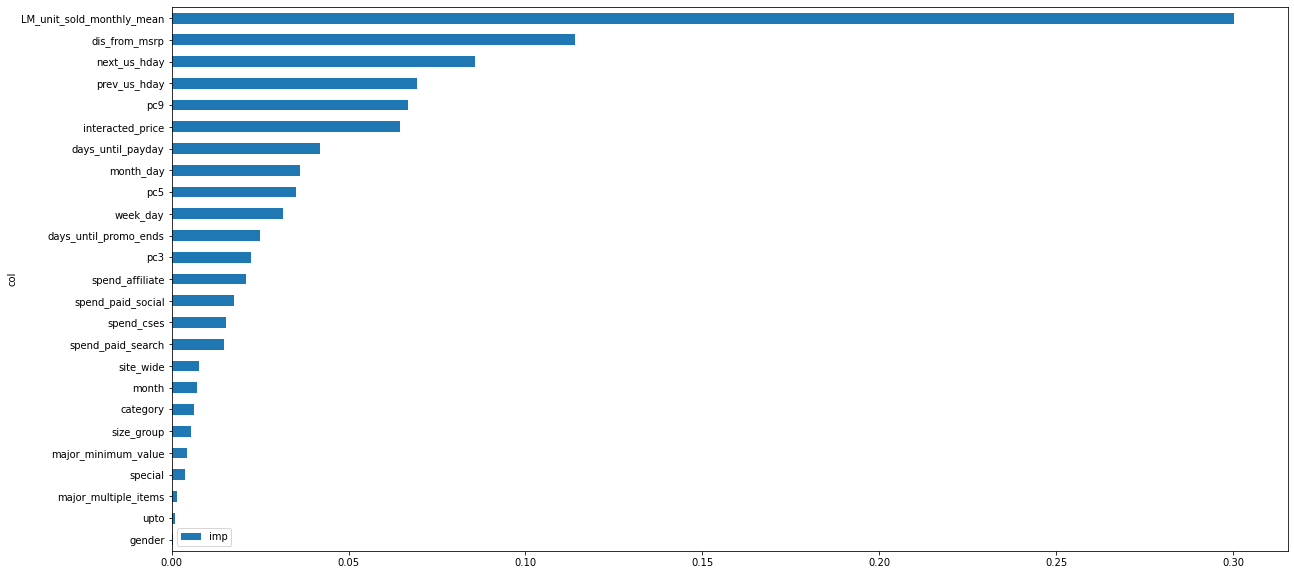

In [ ]:
# forest_model.fit(X_train, y_train)
feature_importance(forest_model, X_train)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

GB_model = GradientBoostingRegressor(learning_rate=0.04)
GB_model.get_params()
# np.mean(cross_val_score(GB_model,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3))

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.04,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
GB_model.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.04, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
test_pred_GB = GB_model.predict(X_val)

In [ ]:
print("MAE GB: ", mean_absolute_error(y_val, test_pred_GB))
print('R2 GB: ', r2_score(y_val, test_pred_GB))
print('MAPE GB: ', MAPE(y_val, test_pred_GB))
# mean_absolute_error(y_val, test_pred_GB)

MAE GB:  1.8411399973167268
R2 GB:  0.3169667580506871
MAPE GB:  95.15307420927385


In [ ]:
# r2_score(y_val, test_pred_GB)

,imp,col
17,0.000000,upto
18,0.000000,special
9,0.000000,size_group
12,0.000000,pc5
11,0.000000,pc3
14,0.000000,major_minimum_value
8,0.000000,gender
15,0.000019,major_multiple_items
13,0.000484,category
5,0.001034,week_day


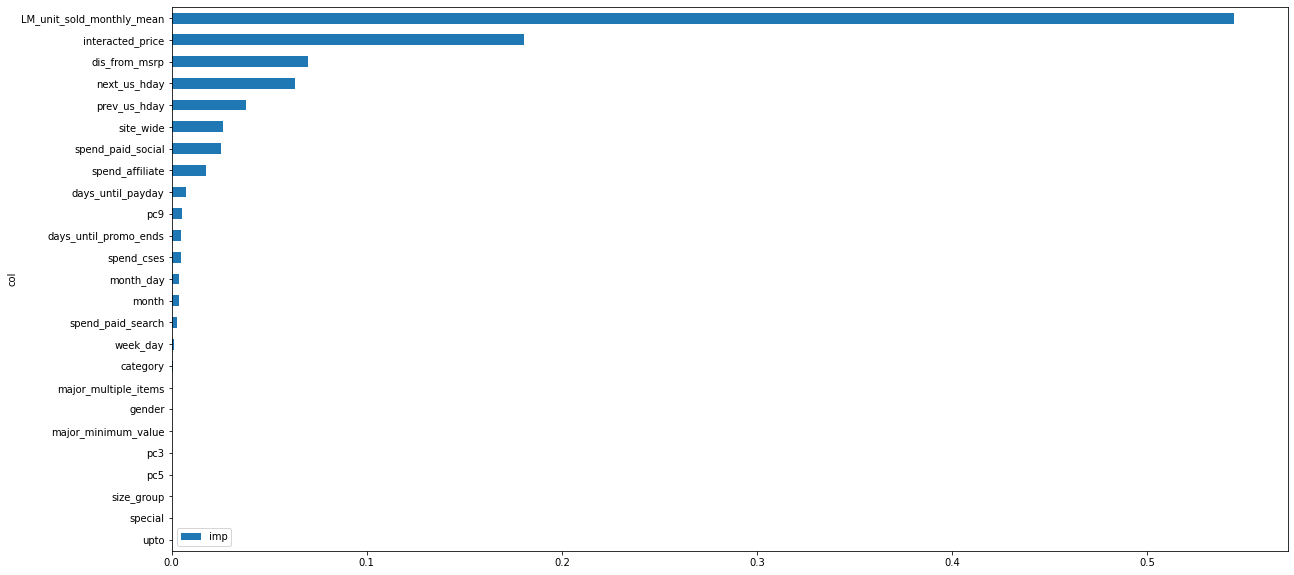

In [ ]:
feature_importance(GB_model, X_train)

In [ ]:
# Catboost with default settings
# cat_model = cb.CatBoostRegressor()

# np.mean(cross_val_score(cat_model, X_train, y_train, scoring = 'neg_mean_absolute_error', cv= 3))

In [ ]:
# cat_model = cb.CatBoostRegressor()


In [ ]:
# cat_model.fit(X_train,y_train, eval_set=(X_val, y_val), cat_features=cat_features)

In [ ]:
# test_pred_catboost = cat_model.predict(X_val)

In [ ]:
# print("MAE CB: ", mean_absolute_error(y_val, test_pred_catboost))
# print('R2 CB: ', r2_score(y_val, test_pred_catboost))
# print('MAPE CB: ', MAPE(y_val, test_pred_catboost))

# mean_absolute_error(y_val, test_pred_catboost)

In [ ]:
# r2_score(y_val, test_pred_catboost)

In [ ]:
# cat_model.get_all_params()

In [ ]:
# feature_importance(cat_model, X_train)

In [ ]:
# i = 100
# print('val set ', list(np.around(y_val,2))[i:i+30])
# # print('forest. ', list(np.around(test_pred_forest,2))[i:i+20])
# # print('GB.     ', list(np.around(test_pred_GB,2))[i:i+20])
# print('catBoost', list(np.around(test_pred_catboost,2))[i:i+30])
# # test_pred_catboost

In [ ]:
# cat_features

In [ ]:
cat_model = cb.CatBoostRegressor(objective = 'Poisson', depth = 8, iterations = 50, od_type = 'Iter', learning_rate = 0.12)
cat_model.fit(X_train,y_train, eval_set=(X_val, y_val), cat_features=cat_features)

0:	learn: 0.7637214	test: 0.7163556	best: 0.7163556 (0)	total: 892ms	remaining: 43.7s
1:	learn: 0.5686644	test: 0.4858321	best: 0.4858321 (1)	total: 1.69s	remaining: 40.5s
2:	learn: 0.3993187	test: 0.3011892	best: 0.3011892 (2)	total: 2.34s	remaining: 36.6s
3:	learn: 0.2639363	test: 0.1622156	best: 0.1622156 (3)	total: 2.99s	remaining: 34.4s
4:	learn: 0.1432024	test: 0.0104192	best: 0.0104192 (4)	total: 3.62s	remaining: 32.6s
5:	learn: 0.0413429	test: -0.0998500	best: -0.0998500 (5)	total: 4.28s	remaining: 31.4s
6:	learn: -0.0336208	test: -0.1947929	best: -0.1947929 (6)	total: 4.95s	remaining: 30.4s
7:	learn: -0.0930946	test: -0.2639821	best: -0.2639821 (7)	total: 5.71s	remaining: 30s
8:	learn: -0.1433516	test: -0.3194845	best: -0.3194845 (8)	total: 6.36s	remaining: 29s
9:	learn: -0.1879515	test: -0.3779096	best: -0.3779096 (9)	total: 7.01s	remaining: 28s
10:	learn: -0.2214464	test: -0.4022074	best: -0.4022074 (10)	total: 7.66s	remaining: 27.2s
11:	learn: -0.2469752	test: -0.4236966	be

In [ ]:
test_pred_catboost = cat_model.predict(X_val)

In [ ]:
print("MAE CB: ", mean_absolute_error(y_val, test_pred_catboost))
print('R2 CB: ', r2_score(y_val, test_pred_catboost))
print('MAPE CB: ', MAPE(y_val, test_pred_catboost))

# mean_absolute_error(y_val, test_pred_catboost)

MAE CB:  1.6901369019699248
R2 CB:  0.358390706618279
MAPE CB:  84.07245235447098


,imp,col
17,0.000000,upto
4,0.000000,month_day
15,0.000000,major_multiple_items
8,0.000000,gender
6,0.000000,days_until_payday
5,0.128244,week_day
9,0.205047,size_group
14,0.412183,major_minimum_value
3,0.465886,month
13,0.689734,category


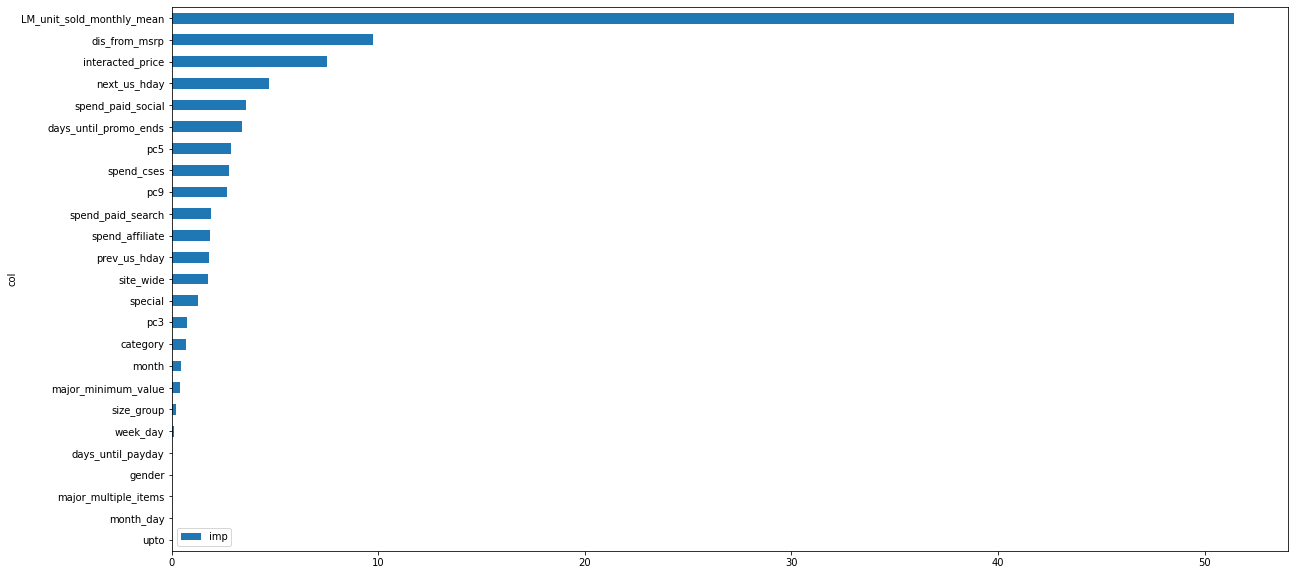

In [ ]:
feature_importance(cat_model, X_train)

In [ ]:
#GridSearch for the parameters optimization

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
model_CBR = cb.CatBoostRegressor()
tscv = TimeSeriesSplit(n_splits=5)
parameters = {'depth'         : [8,10],
              'learning_rate' : [0.03, 0.08, 0.12],
              'iterations'    : [50, 100]
              }

In [ ]:

grid = GridSearchCV(estimator=model_CBR, param_grid = parameters, cv = tscv)
grid.fit(X_train,y_train, eval_set=(X_val, y_val), cat_features=cat_features)


0:	learn: 3.9937679	test: 4.6070185	best: 4.6070185 (0)	total: 138ms	remaining: 6.76s
1:	learn: 3.9573196	test: 4.5788008	best: 4.5788008 (1)	total: 256ms	remaining: 6.15s
2:	learn: 3.9247123	test: 4.5561112	best: 4.5561112 (2)	total: 331ms	remaining: 5.18s
3:	learn: 3.8846579	test: 4.5263904	best: 4.5263904 (3)	total: 433ms	remaining: 4.97s
4:	learn: 3.8426622	test: 4.5044538	best: 4.5044538 (4)	total: 508ms	remaining: 4.57s
5:	learn: 3.8054815	test: 4.4816413	best: 4.4816413 (5)	total: 723ms	remaining: 5.3s
6:	learn: 3.7709485	test: 4.4554703	best: 4.4554703 (6)	total: 807ms	remaining: 4.96s
7:	learn: 3.7461949	test: 4.4334075	best: 4.4334075 (7)	total: 883ms	remaining: 4.64s
8:	learn: 3.7214788	test: 4.4146230	best: 4.4146230 (8)	total: 960ms	remaining: 4.38s
9:	learn: 3.6907257	test: 4.3923094	best: 4.3923094 (9)	total: 1.03s	remaining: 4.13s
10:	learn: 3.6666061	test: 4.3737400	best: 4.3737400 (10)	total: 1.1s	remaining: 3.92s
11:	learn: 3.6416124	test: 4.3572843	best: 4.3572843 (

In [ ]:
grid.cv_results_
# cat_features

In [ ]:
grid.best_params_

In [ ]:

# X_train.info()

In [ ]:
# cat_model = cb.CatBoostRegressor(objective = 'Poisson', depth = 10, iterations = 20, od_type = 'Iter', learning_rate = 0.04)

In [ ]:
# cat_model.fit(X_train,y_train, eval_set=(X_val, y_val), cat_features=cat_features)

In [ ]:
# test_pred_catboost = cat_model.predict(X_val)

In [ ]:
i = 1
# print('val set ', list(np.around(y_val,2))[i:i+20])
# print('forest. ', list(np.around(test_pred_forest,2))[i:i+20])
# print('GB.     ', list(np.around(test_pred_GB,2))[i:i+20])
# print('catBoost', list(np.around(test_pred_catboost,2))[i:i+20])
# test_pred_catboost

In [ ]:
# print('forest: ', mean_absolute_error(y_val, test_pred_forest))
# print('GB: ', mean_absolute_error(y_val, test_pred_GB))
# print('catboost: ', mean_absolute_error(y_val, test_pred_catboost))